In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
import itertools
matplotlib.rc('font', family='Tahoma')

In [3]:
PATH = "data/dead/"

Import data ผู้บาดเจ็บและเสียชีวิต ในช่วงเทศกาลปีใหม่ ปี 2551-2558 , ข้อมูลพื้นฐานโรงพยาบาลในสังกัดสำนักงานปลัดกระทรวงสาธารณสุข ณ มกราคม 2560, then convert to csv and cut off redundant data from http://opendata.moph.go.th/#

In [4]:
df_raw = pd.read_excel(f'{PATH}ny.xlsx')

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(df_raw.tail())

,ชื่อเทศกาล,รหัสจังหวัด,จังหวัด,รหัส รพ.,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,วันที่เกิดเหตุ,เวลาเกิดเหตุ,เพศ,อายุ,ถนนที่เกิดเหตุ,สถานะ,รถผู้บาดเจ็บ,รถคู่กรณี,มาตรการ,การดื่มสุรา,การนำส่ง,Refer-Admit,ผลการรักษา,จำนวนวันรักษา
214945,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,31,09:01-10:00 น.,ชาย,3,ชนบท,คนเดินเท้า,ไม่มี/ล้มเอง,จักรยานยนต์,ไม่ใส่,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0
214946,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,30,16:01-17:00 น.,หญิง,4,ชนบท,คนเดินเท้า,ไม่มี/ล้มเอง,จักรยานยนต์,ไม่ใส่,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0
214947,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,30,24:01-01:00 น.,ชาย,20,ชนบท,ผู้ชับขี่,จักรยานยนต์,ปิคอัพ,ไม่ใส่,ไม่ดื่ม,ALS,ส่งต่อก่อน admit,ทุเลา/หาย,0
214948,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,31,14:01-15:00 น.,ชาย,16,ชนบท,ผู้ชับขี่,จักรยานยนต์,ไม่มี/ล้มเอง,ไม่ใส่,ดื่ม,FR,ส่งต่อก่อน admit,ทุเลา/หาย,0
214949,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,5,15:01-16:00 น.,ชาย,19,ทางหลวง,ผู้ชับขี่,จักรยานยนต์,สามล้อเครื่อง,ใส่หมวก,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ส่งต่อก่อน admit,ทุเลา/หาย,0


In [7]:
#Government hospital data
hospgov = pd.read_csv(f'{PATH}hospgov.csv')

#Private hospital data
hospbus = pd.read_csv(f'{PATH}hosp.csv')

In [8]:
hospgov.tail()

,ชื่อหน่วยงาน,ประเภทหน่วยงาน,จำนวนเตียงจริง_2559
891,ควนกาหลง,ชุมชน,33
892,ควนโดน,ชุมชน,30
893,ท่าแพ,ชุมชน,33
894,ทุ่งหว้า,ชุมชน,30
895,มะนัง,ชุมชน,30


Combine Hospital data from both sources

In [9]:
hospbus.loc[:,'ประเภทหน่วยงาน'] = 'เอกชน'

In [10]:
hospbus.rename(index=str, columns={"Hosp": "ชื่อหน่วยงาน", "Bed": "จำนวนเตียงจริง_2559"}, inplace = True)

In [11]:
hospbus = hospbus[['ชื่อหน่วยงาน', 'ประเภทหน่วยงาน', 'จำนวนเตียงจริง_2559']]

In [12]:
hospbus.tail()

,ชื่อหน่วยงาน,ประเภทหน่วยงาน,จำนวนเตียงจริง_2559
320,เอกอุดร,เอกชน,100
321,นอร์ทอีสเทอร์นวัฒนา,เอกชน,100
322,ราชเวชอุบลราชธานี,เอกชน,100
323,อุบลรักษ์ ธนบุรี,เอกชน,100
324,เอกชนร่มเกล้า,เอกชน,50


In [13]:
hosp = hospgov.append(hospbus, ignore_index=True)

In [14]:
hosp.tail()

,ชื่อหน่วยงาน,ประเภทหน่วยงาน,จำนวนเตียงจริง_2559
1216,เอกอุดร,เอกชน,100
1217,นอร์ทอีสเทอร์นวัฒนา,เอกชน,100
1218,ราชเวชอุบลราชธานี,เอกชน,100
1219,อุบลรักษ์ ธนบุรี,เอกชน,100
1220,เอกชนร่มเกล้า,เอกชน,50


In [15]:
hosp.rename(index=str, columns={"ชื่อหน่วยงาน": "ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ"}, inplace = True)

Join hospitals detail to main data by column 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ'

In [16]:
df_raw = df_raw.join(hosp.set_index('ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ'), on='ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ')

In [17]:
display_all(df_raw.tail())

,ชื่อเทศกาล,รหัสจังหวัด,จังหวัด,รหัส รพ.,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,วันที่เกิดเหตุ,เวลาเกิดเหตุ,เพศ,อายุ,ถนนที่เกิดเหตุ,สถานะ,รถผู้บาดเจ็บ,รถคู่กรณี,มาตรการ,การดื่มสุรา,การนำส่ง,Refer-Admit,ผลการรักษา,จำนวนวันรักษา,ประเภทหน่วยงาน,จำนวนเตียงจริง_2559
214945,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,31,09:01-10:00 น.,ชาย,3,ชนบท,คนเดินเท้า,ไม่มี/ล้มเอง,จักรยานยนต์,ไม่ใส่,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0,ชุมชน,38.0
214946,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,30,16:01-17:00 น.,หญิง,4,ชนบท,คนเดินเท้า,ไม่มี/ล้มเอง,จักรยานยนต์,ไม่ใส่,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0,ชุมชน,38.0
214947,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,30,24:01-01:00 น.,ชาย,20,ชนบท,ผู้ชับขี่,จักรยานยนต์,ปิคอัพ,ไม่ใส่,ไม่ดื่ม,ALS,ส่งต่อก่อน admit,ทุเลา/หาย,0,ชุมชน,38.0
214948,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,31,14:01-15:00 น.,ชาย,16,ชนบท,ผู้ชับขี่,จักรยานยนต์,ไม่มี/ล้มเอง,ไม่ใส่,ดื่ม,FR,ส่งต่อก่อน admit,ทุเลา/หาย,0,ชุมชน,38.0
214949,ปีใหม่ 58,97,บึงกาฬ,11049,ศรีวิไล,5,15:01-16:00 น.,ชาย,19,ทางหลวง,ผู้ชับขี่,จักรยานยนต์,สามล้อเครื่อง,ใส่หมวก,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ส่งต่อก่อน admit,ทุเลา/หาย,0,ชุมชน,38.0


In [18]:
#Find missing value of hosp bed and replace available data from Wikipedia
df_raw.loc[(df_raw["จำนวนเตียงจริง_2559"] == 0)].tail()

,ชื่อเทศกาล,รหัสจังหวัด,จังหวัด,รหัส รพ.,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,วันที่เกิดเหตุ,เวลาเกิดเหตุ,เพศ,อายุ,ถนนที่เกิดเหตุ,...,รถผู้บาดเจ็บ,รถคู่กรณี,มาตรการ,การดื่มสุรา,การนำส่ง,Refer-Admit,ผลการรักษา,จำนวนวันรักษา,ประเภทหน่วยงาน,จำนวนเตียงจริง_2559
207881,ปีใหม่ 58,66,พิจิตร,27978,สากเหล็ก,2,10:01-11:00 น.,หญิง,13,ชนบท,...,จักรยานยนต์,ปิคอัพ,ไม่ใส่,ไม่ดื่ม,FR,ไม่,ทุเลา/หาย,0,ชุมชน,0.0
207882,ปีใหม่ 58,66,พิจิตร,27978,สากเหล็ก,31,10:01-11:00 น.,ชาย,45,ทางหลวง,...,ปิคอัพ,รถเก๋ง/แท็กซี่,ไม่ทราบ,ไม่ทราบ,FR,ไม่,ทุเลา/หาย,0,ชุมชน,0.0
207883,ปีใหม่ 58,66,พิจิตร,27978,สากเหล็ก,2,10:01-11:00 น.,หญิง,14,ชนบท,...,จักรยานยนต์,ปิคอัพ,ไม่ใส่,ไม่ดื่ม,FR,ส่งต่อก่อน admit,ทุเลา/หาย,0,ชุมชน,0.0
207884,ปีใหม่ 58,66,พิจิตร,27978,สากเหล็ก,30,11:01-12:00 น.,ชาย,4,ทางหลวง,...,จักรยานยนต์,ไม่มี/ล้มเอง,ใส่หมวก,ไม่ดื่ม,FR,ส่งต่อก่อน admit,ทุเลา/หาย,0,ชุมชน,0.0
207885,ปีใหม่ 58,66,พิจิตร,27978,สากเหล็ก,30,11:01-12:00 น.,ชาย,26,ทางหลวง,...,จักรยานยนต์,ไม่มี/ล้มเอง,ใส่หมวก,ดื่ม,FR,ส่งต่อก่อน admit,ทุเลา/หาย,0,ชุมชน,0.0


In [19]:
df_raw.loc[(df_raw["ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ"] == "เฉลิมพระเกียรติ") & (df_raw["จำนวนเตียงจริง_2559"] == 0), "จำนวนเตียงจริง_2559"] = 30

In [20]:
# Convert to PD datetime format and drop redundant columns

In [21]:
convert_to_year = (df_raw.ชื่อเทศกาล.str.split(" ").str[-1].astype(int) + 1957).astype(str) + " "

In [22]:
def conv_month(x, dec, jan):
    if x > 20:
        x = str(x)+ dec 
    else:
        x = str(x)+ jan 
    return x
ac_day = df_raw.วันที่เกิดเหตุ.copy()
ac_day[ac_day==0] = 30
ac_day = ac_day.apply(conv_month, args=('/12/', '/1/'))

In [23]:
ac_time = df_raw.เวลาเกิดเหตุ.str.split("-").str[0]
#Convert 24:01 to 0:01 , convert unknown to 0:00
ac_time[ac_time=="24:01"] = "0:01"
ac_time[ac_time=="ไม่ทราบ"] = "0:00"

In [24]:
ac_day = ac_day+convert_to_year+ac_time

In [25]:
dead_day = pd.Series([], name="date")

df_raw['dates']= pd.to_datetime(ac_day, format='%d/%m/%Y %H:%M')
df_raw.drop(['ชื่อเทศกาล','เวลาเกิดเหตุ','รหัสจังหวัด','รหัส รพ.'], axis=1, inplace=True)
df_raw.head()

,จังหวัด,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,วันที่เกิดเหตุ,เพศ,อายุ,ถนนที่เกิดเหตุ,สถานะ,รถผู้บาดเจ็บ,รถคู่กรณี,มาตรการ,การดื่มสุรา,การนำส่ง,Refer-Admit,ผลการรักษา,จำนวนวันรักษา,ประเภทหน่วยงาน,จำนวนเตียงจริง_2559,dates
0,กรุงเทพมหานคร,กรุงเทพ,3,หญิง,54,ในเมือง,ผู้ชับขี่,รถเก๋ง/แท็กซี่,ไม่มี/ล้มเอง,เข็มขัด,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0,เอกชน,403.0,2008-01-03 12:01:00
1,กรุงเทพมหานคร,กรุงเทพคริสเตียน,2,หญิง,13,ในเมือง,ผู้ชับขี่,จักรยานยนต์,รถตู้,ใส่หมวก,ไม่ดื่ม,มูลนิธิ/อาสาสมัคร,admit,ทุเลา/หาย,0,เอกชน,198.0,2008-01-02 21:01:00
2,กรุงเทพมหานคร,กรุงเทพคริสเตียน,31,หญิง,0,ในเมือง,ผู้โดยสาร,จักรยานยนต์,ปิคอัพ,ไม่ใส่,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0,เอกชน,198.0,2008-12-31 03:01:00
3,กรุงเทพมหานคร,กรุงเทพคริสเตียน,31,หญิง,0,ในเมือง,ผู้โดยสาร,จักรยานยนต์,ปิคอัพ,ใส่หมวก,ไม่ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0,เอกชน,198.0,2008-12-31 03:01:00
4,กรุงเทพมหานคร,กรุงเทพคริสเตียน,31,ชาย,0,ในเมือง,ผู้ชับขี่,จักรยานยนต์,ปิคอัพ,ใส่หมวก,ดื่ม,ผู้ประสบเหตุ/ญาติ,ไม่,ทุเลา/หาย,0,เอกชน,198.0,2008-12-31 03:01:00


In [26]:
#Convert ผลการรักษา to 0(Dead) or 1(Alive)
df_raw['result'] = df_raw['ผลการรักษา']
df_raw.loc[df_raw['result'] != 'ทุเลา/หาย','result'] = 0
df_raw.loc[df_raw['result'] == 'ทุเลา/หาย','result'] = 1
df_raw.drop(['ผลการรักษา'], axis=1, inplace=True)

In [27]:
#Remove and fill in confusing data
df_raw.loc[((df_raw["รถผู้บาดเจ็บ"] == "ไม่มี/ล้มเอง") & (df_raw["สถานะ"] != "คนเดินเท้า")), "รถผู้บาดเจ็บ"] = "จักรยานยนต์"
df_raw.loc[((df_raw["รถผู้บาดเจ็บ"] == "ไม่มี/ล้มเอง") & (df_raw["สถานะ"] == "คนเดินเท้า")), "รถผู้บาดเจ็บ"] = "ไม่มี" 
df_raw.loc[((df_raw["มาตรการ"]=="ไม่ใส่")&(df_raw["สถานะ"]=="คนเดินเท้า")), "มาตรการ"] = "คนเดินเท้า"
df_raw.loc[((df_raw["มาตรการ"]=="ไม่ทราบ")&(df_raw["สถานะ"]=="คนเดินเท้า")), "มาตรการ"] = "คนเดินเท้า"

In [28]:
#Create year's end and new year
df_raw['is_year_end'] = 0
df_raw['is_new_year'] = 0
df_raw.loc[df_raw['วันที่เกิดเหตุ'] == 31,'is_year_end'] = 1
df_raw.loc[df_raw['วันที่เกิดเหตุ'] == 1,'is_new_year'] = 1
df_raw.drop(['วันที่เกิดเหตุ'], axis=1, inplace=True)

In [29]:
#Create ALS, BLS, ILS
df_raw['BLS'] = 0
df_raw['ALS'] = 0
df_raw['ILS'] = 0
df_raw.loc[df_raw['การนำส่ง'] == 'BLS','BLS'] = 1
df_raw.loc[df_raw['การนำส่ง'] == 'ALS','ALS'] = 1
df_raw.loc[df_raw['การนำส่ง'] == 'ILS','ILS'] = 1
df_raw.drop(['การนำส่ง'], axis=1, inplace=True)

In [30]:
#Grouping the enemy's vehicle

In [31]:
df_raw['vehicle'] = ''
df_raw.loc[df_raw['รถคู่กรณี'].isin(['จักรยานยนต์','สามล้อถีบ','รถจักรยาน','สามล้อเครื่อง']),'vehicle'] = "Small"
df_raw.loc[df_raw['รถคู่กรณี'].isin(['รถโดยสาร 4 ล้อ','รถเก๋ง/แท็กซี่','ปิคอัพ','รถตู้']),'vehicle'] = "Medium"
df_raw.loc[df_raw['รถคู่กรณี'].isin(['รถบรรทุก','รถโดยสารใหญ่']),'vehicle'] = "Large"
df_raw.loc[df_raw['รถคู่กรณี'].isin(['อื่นๆ','ไม่ทราบ']),'vehicle'] = "Unknown"
df_raw.loc[df_raw['รถคู่กรณี'] == 'ไม่มี/ล้มเอง', 'vehicle'] = "Self"
df_raw.drop(['รถคู่กรณี'], axis=1, inplace=True)

In [32]:
#Grouping age
df_raw['age'] = df_raw['อายุ']
df_raw.loc[(df_raw['อายุ'] >=1) & (df_raw['อายุ'] <=12), 'age'] = "child"
df_raw.loc[(df_raw['อายุ'] >=13) & (df_raw['อายุ'] <=18), 'age'] = "youth"
df_raw.loc[(df_raw['อายุ'] >=19) & (df_raw['อายุ'] <=30), 'age'] = "early adult"
df_raw.loc[(df_raw['อายุ'] >=31) & (df_raw['อายุ'] <=45), 'age'] = "late adult"
df_raw.loc[(df_raw['อายุ'] >=46) & (df_raw['อายุ'] <=60), 'age'] = "early senior"
df_raw.loc[df_raw['อายุ'] >=61, 'age'] = "senior"
df_raw.loc[df_raw['อายุ'] ==0, 'age'] = "Unknown"

In [33]:
#Grouping Region
df_raw['region'] = ''
df_raw.loc[df_raw['จังหวัด'].isin(["เชียงราย","เชียงใหม่","น่าน","พะเยา","แพร่","แม่ฮ่องสอน","ลำปาง","ลำพูน","อุตรดิตถ์"]),"region"] = "North"
df_raw.loc[df_raw['จังหวัด'].isin(["กาฬสินธุ์","ขอนแก่น","ชัยภูมิ","นครพนม","นครราชสีมา","บึงกาฬ","บุรีรัมย์","มหาสารคาม","มุกดาหาร","ยโสธร","ร้อยเอ็ด","เลย","ศรีสะเกษ","สกลนคร","สุรินทร์","หนองคาย","หนองบัวลำภู","อำนาจเจริญ","อุดรธานี","อุบลราชธานี"]),"region"] = "Northeast"
df_raw.loc[df_raw['จังหวัด'].isin(["กาญจนบุรี","ตาก","ประจวบคีรีขันธ์","เพชรบุรี","ราชบุรี"]),"region"] = "West"
df_raw.loc[df_raw['จังหวัด'].isin(["กรุงเทพมหานคร","กำแพงเพชร","ชัยนาท","นครนายก","นครปฐม","นครสวรรค์","นนทบุรี","ปทุมธานี","พระนครศรีอยุธยา","พิจิตร","พิษณุโลก","เพชรบูรณ์","ลพบุรี","สมุทรปราการ","สมุทรสงคราม","สมุทรสาคร","สระบุรี","สิงห์บุรี","สุโขทัย","สุพรรณบุรี","อ่างทอง","อุทัยธานี"]
),"region"] = "Central"
df_raw.loc[df_raw['จังหวัด'].isin(["จันทบุรี","ชลบุรี","ตราด","ระยอง","ฉะเชิงเทรา","ปราจีนบุรี","สระแก้ว"]),"region"] = "East"
df_raw.loc[df_raw['จังหวัด'].isin(["กระบี่","ชุมพร","ตรัง","นครศรีธรรมราช","นราธิวาส","ปัตตานี","พังงา","พัทลุง","ภูเก็ต","ยะลา","ระนอง","สงขลา","สตูล","สุราษฎร์ธานี"]),"region"] = "South"

In [34]:
df_raw.tail().T

,214945,214946,214947,214948,214949
จังหวัด,บึงกาฬ,บึงกาฬ,บึงกาฬ,บึงกาฬ,บึงกาฬ
ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,ศรีวิไล,ศรีวิไล,ศรีวิไล,ศรีวิไล,ศรีวิไล
เพศ,ชาย,หญิง,ชาย,ชาย,ชาย
อายุ,3,4,20,16,19
ถนนที่เกิดเหตุ,ชนบท,ชนบท,ชนบท,ชนบท,ทางหลวง
สถานะ,คนเดินเท้า,คนเดินเท้า,ผู้ชับขี่,ผู้ชับขี่,ผู้ชับขี่
รถผู้บาดเจ็บ,ไม่มี,ไม่มี,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์
มาตรการ,คนเดินเท้า,คนเดินเท้า,ไม่ใส่,ไม่ใส่,ใส่หมวก
การดื่มสุรา,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ดื่ม,ไม่ดื่ม
Refer-Admit,ไม่,ไม่,ส่งต่อก่อน admit,ส่งต่อก่อน admit,ส่งต่อก่อน admit


From here, we will using Fastai library, to convert data to category, and using feature add_datepart

In [35]:
train_cats(df_raw)

In [36]:
add_datepart(df_raw, 'dates')

In [37]:
df_raw.drop(["datesIs_month_end","datesIs_month_start","datesIs_quarter_end","datesIs_quarter_start","datesIs_year_end","datesIs_quarter_start","datesIs_year_end","datesIs_year_start","datesElapsed","อายุ","จังหวัด"], axis=1, inplace=True)

proc_df is also from Fastai library, that split X and y from data easily

In [38]:
df, y, nas, mapper = proc_df(df_raw, 'result', do_scale=True)

In [39]:
df_raw.head().T

,0,1,2,3,4
ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,กรุงเทพ,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน
เพศ,หญิง,หญิง,หญิง,หญิง,ชาย
ถนนที่เกิดเหตุ,ในเมือง,ในเมือง,ในเมือง,ในเมือง,ในเมือง
สถานะ,ผู้ชับขี่,ผู้ชับขี่,ผู้โดยสาร,ผู้โดยสาร,ผู้ชับขี่
รถผู้บาดเจ็บ,รถเก๋ง/แท็กซี่,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์
มาตรการ,เข็มขัด,ใส่หมวก,ไม่ใส่,ใส่หมวก,ใส่หมวก
การดื่มสุรา,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ดื่ม
Refer-Admit,ไม่,admit,ไม่,ไม่,ไม่
จำนวนวันรักษา,0,0,0,0,0
ประเภทหน่วยงาน,เอกชน,เอกชน,เอกชน,เอกชน,เอกชน


In [40]:
df_raw = df_raw.reset_index()

In [41]:
df_raw.drop(["index"], axis = 1, inplace=True)

In [42]:
df_raw.head().T

,0,1,2,3,4
ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,กรุงเทพ,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน
เพศ,หญิง,หญิง,หญิง,หญิง,ชาย
ถนนที่เกิดเหตุ,ในเมือง,ในเมือง,ในเมือง,ในเมือง,ในเมือง
สถานะ,ผู้ชับขี่,ผู้ชับขี่,ผู้โดยสาร,ผู้โดยสาร,ผู้ชับขี่
รถผู้บาดเจ็บ,รถเก๋ง/แท็กซี่,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์
มาตรการ,เข็มขัด,ใส่หมวก,ไม่ใส่,ใส่หมวก,ใส่หมวก
การดื่มสุรา,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ดื่ม
Refer-Admit,ไม่,admit,ไม่,ไม่,ไม่
จำนวนวันรักษา,0,0,0,0,0
ประเภทหน่วยงาน,เอกชน,เอกชน,เอกชน,เอกชน,เอกชน


Save/Load data as feather

In [43]:
df_raw.to_feather(f'{PATH}df')

In [44]:
df_raw = pd.read_feather(f'{PATH}df')

Split into Train set and Validation set, using the last year data (2015) as a validation set

In [45]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 24117  # Latest year (2015)
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((191830, 26), (191830,), (24117, 26))

Fit in RandomForestClassifier, of course we would get a good score here , because the dead rate is only 1.2% of the data. Everyone can predict this data by telling that everybody survive, the error rate will be around 1-2%

What we interest in this dataset is its features or risk factors that may can caused deadly accident.

In [46]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, class_weight="balanced", oob_score=True)
m.fit(X_train, y_train)
m.score(X_valid,y_valid)

0.98469958950118175

In [47]:
def print_score(m):
    res = [m.predict(X_train), m.predict(X_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [48]:
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.99752384924151594, 0.98469958950118175, 0.98257311160923733]


In [49]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]),
 1.0,
 1)

In [50]:
preds.shape

(40, 24117)

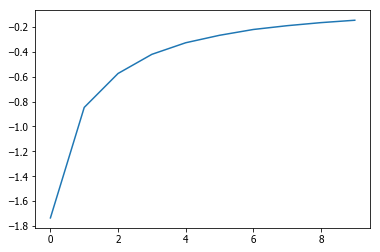

In [51]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

We use only 50,000 example to save computing time, and increase trees to 80. The OOB score is not improved.

In [52]:
set_rf_samples(50000)

 Try increase more trees, seems it doesn't help much.

In [53]:
m = RandomForestClassifier(n_estimators=80, min_samples_leaf=3, max_features=0.3, n_jobs=-1, oob_score=True, class_weight='balanced')
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98643069384350723, 0.98482398308247299, 0.98392847834019703]


In [54]:
#using STD instead of Mean
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 371 ms, sys: 57.9 ms, total: 429 ms
Wall time: 431 ms


(0.98750000000000004, 0.11110243021644485)

In [55]:
from pandas_summary import DataFrameSummary

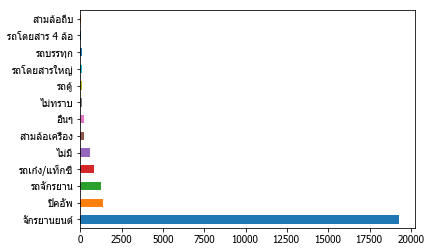

In [56]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.รถผู้บาดเจ็บ.value_counts().plot.barh();

In [57]:
flds = ['รถผู้บาดเจ็บ', 'result', 'pred', 'pred_std']
enc_summ = x[flds].groupby('รถผู้บาดเจ็บ', as_index=False).mean()
enc_summ

,รถผู้บาดเจ็บ,result,pred,pred_std
0,จักรยานยนต์,0.988500,0.969158,0.116954
1,ปิคอัพ,0.963323,0.942796,0.192732
2,รถจักรยาน,0.988553,0.969287,0.124542
3,รถตู้,0.990099,0.941955,0.187989
4,รถบรรทุก,0.986301,0.951712,0.168845
5,รถเก๋ง/แท็กซี่,0.966080,0.949278,0.179124
6,รถโดยสาร 4 ล้อ,0.980769,0.961779,0.162811
7,รถโดยสารใหญ่,0.987342,0.964557,0.153202
8,สามล้อถีบ,0.950000,0.927500,0.172961
9,สามล้อเครื่อง,0.969565,0.954022,0.175930


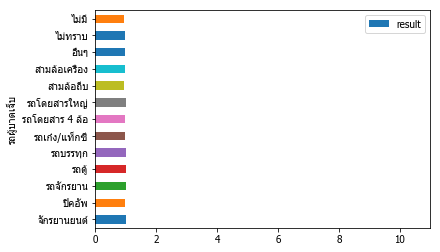

In [58]:
enc_summ = enc_summ[~pd.isnull(enc_summ.result)]
enc_summ.plot('รถผู้บาดเจ็บ', 'result', 'barh', xlim=(0,11));

This section is about Feature importance, which what we would like to extract from this dataset.
The rf_feat_importance came from Fastai library

In [62]:
#Feature importance

In [59]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
6,การดื่มสุรา,0.183990
0,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,0.106282
16,vehicle,0.087553
10,จำนวนเตียงจริง_2559,0.079981
17,age,0.046611
14,ALS,0.044306
19,datesYear,0.044197
18,region,0.040352
23,datesDayofweek,0.039974
2,ถนนที่เกิดเหตุ,0.037999


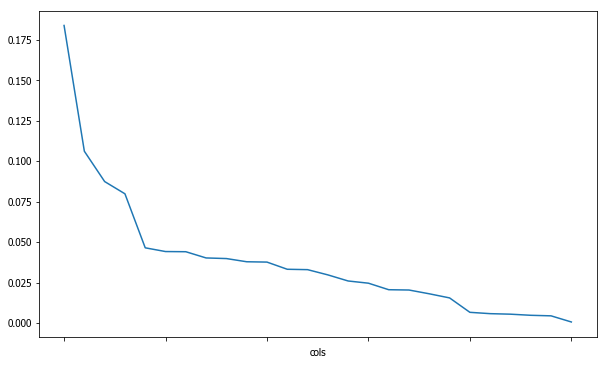

In [60]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [61]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

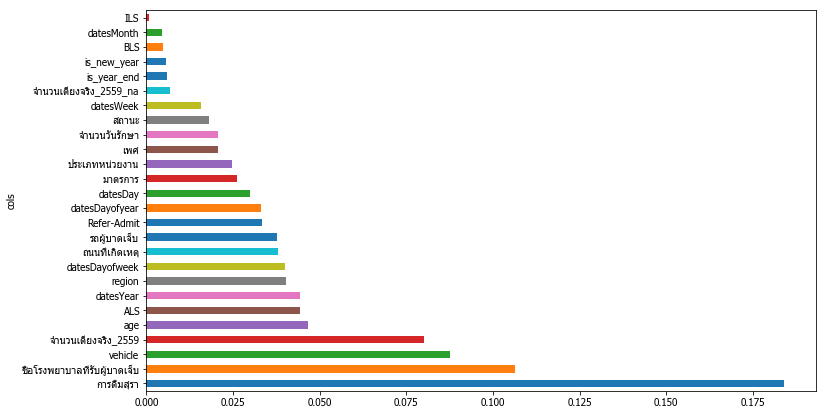

In [62]:
plot_fi(fi[:30]);

What we see here is การดื่มสุรา is the most important feature, as expected. 
But is it really true? We will see...

Next we remove unimportant features, keep only ones with imp >0.005

In [63]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [64]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [65]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True, class_weight='balanced')
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98587812125319296, 0.98478251855537591, 0.98355314601470056]


Look like the scores improved a bit after we removed redundant features. Also the ranking now is different from before.

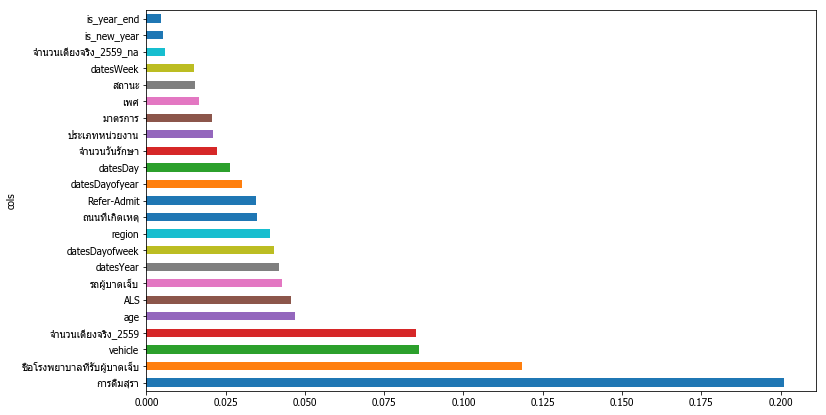

In [66]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

Here we use OneHotEncoding, then plot the feature importance again. 
You see here that the most important one is actually 
unknown Alc. drinking.

In [67]:
#One Hot Encoding
df_trn2, y_trn, nas = proc_df(df_raw, 'result', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestClassifier(n_estimators=40,class_weight="balanced", min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98599801907939322, 0.98445080233859927, 0.98377208987124021]


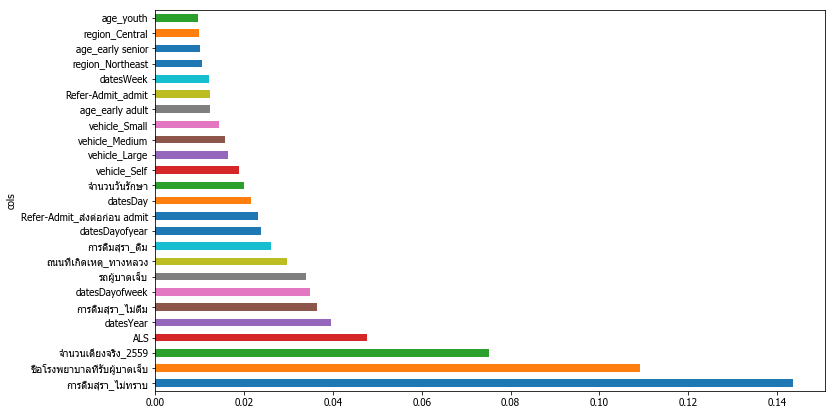

In [68]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [69]:
#Fill data of unknown drink

In [70]:
df_raw.loc[df_raw['การดื่มสุรา']=="ไม่ทราบ",['การดื่มสุรา','เพศ']].describe()

,การดื่มสุรา,เพศ
count,13278,13278
unique,1,2
top,ไม่ทราบ,ชาย
freq,13278,9351


In [71]:
df_raw.loc[df_raw['การดื่มสุรา']=="ดื่ม",['การดื่มสุรา','เพศ']].describe()

,การดื่มสุรา,เพศ
count,75857,75857
unique,1,2
top,ดื่ม,ชาย
freq,75857,69312


In [72]:
df_raw.loc[df_raw['การดื่มสุรา']=="ไม่ดื่ม",['การดื่มสุรา','เพศ']].describe()

,การดื่มสุรา,เพศ
count,126812,126812
unique,1,2
top,ไม่ดื่ม,ชาย
freq,126812,67187


In [73]:
total_known_drink = 126812+75857
total_male_known_hx_drink = 69312+67187
total_female_known_hx_drink = (75857-68312) + (126812-67187)
total_male_who_drink = 69312 / total_male_known_hx_drink
total_female_who_drink = (75857-69312) / total_female_known_hx_drink
print("Male drink :" f"{total_male_who_drink}" )
print("Female drink :" f"{total_female_who_drink}" )

Male drink :0.5077839398090829
Female drink :0.09743933303558136


We estimate percentage of drinkers in men and women, and use the data to fill in the missing value.

In [74]:
idxm = df_raw.index[(df_raw['การดื่มสุรา']=="ไม่ทราบ") & (df_raw['เพศ']=="ชาย")].tolist()
idxf = df_raw.index[(df_raw['การดื่มสุรา']=="ไม่ทราบ") & (df_raw['เพศ']=="หญิง")].tolist()

In [75]:
import random
ran_m = random.sample(idxm,int(len(idxm)*0.5074))
ran_f = random.sample(idxf,int(len(idxf)*0.0988))

In [76]:
df_raw.head().T

,0,1,2,3,4
ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,กรุงเทพ,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน,กรุงเทพคริสเตียน
เพศ,หญิง,หญิง,หญิง,หญิง,ชาย
ถนนที่เกิดเหตุ,ในเมือง,ในเมือง,ในเมือง,ในเมือง,ในเมือง
สถานะ,ผู้ชับขี่,ผู้ชับขี่,ผู้โดยสาร,ผู้โดยสาร,ผู้ชับขี่
รถผู้บาดเจ็บ,รถเก๋ง/แท็กซี่,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์,จักรยานยนต์
มาตรการ,เข็มขัด,ใส่หมวก,ไม่ใส่,ใส่หมวก,ใส่หมวก
การดื่มสุรา,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ไม่ดื่ม,ดื่ม
Refer-Admit,ไม่,admit,ไม่,ไม่,ไม่
จำนวนวันรักษา,0,0,0,0,0
ประเภทหน่วยงาน,เอกชน,เอกชน,เอกชน,เอกชน,เอกชน


In [77]:
df_raw.iloc[ran_m,6] = 'ดื่ม'
df_raw.iloc[list(set(idxm) - set(ran_m)),6] = 'ไม่ดื่ม'
df_raw.iloc[ran_f,6] = 'ดื่ม'
df_raw.iloc[list(set(idxf) - set(ran_f)),6] = 'ไม่ดื่ม'

In [78]:
df_raw.loc[df_raw['การดื่มสุรา']=="ไม่ทราบ"]

,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,เพศ,ถนนที่เกิดเหตุ,สถานะ,รถผู้บาดเจ็บ,มาตรการ,การดื่มสุรา,Refer-Admit,จำนวนวันรักษา,ประเภทหน่วยงาน,...,ILS,vehicle,age,region,datesYear,datesMonth,datesWeek,datesDay,datesDayofweek,datesDayofyear


In [79]:
train_cats(df_raw)

In [80]:
df, y, nas, mapper = proc_df(df_raw, 'result', do_scale=True)

In [81]:
df_raw.to_feather(f'{PATH}df')
df_raw = pd.read_feather(f'{PATH}df')

In [82]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 24117  # Latest year (2015)
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((191830, 26), (191830,), (24117, 26))

In [83]:
df_trn2, y_trn, nas = proc_df(df_raw, 'result')
m = RandomForestClassifier(n_estimators=40,class_weight="balanced", min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98491372569462543, 0.98461666044698759, 0.98323515612782153]


In [84]:
fi = rf_feat_importance(m, df_trn2); fi[:10]

,cols,imp
0,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,0.140528
16,vehicle,0.111396
10,จำนวนเตียงจริง_2559,0.103617
17,age,0.056857
19,datesYear,0.051272
14,ALS,0.050276
23,datesDayofweek,0.047460
5,มาตรการ,0.045718
4,รถผู้บาดเจ็บ,0.045298
18,region,0.044567


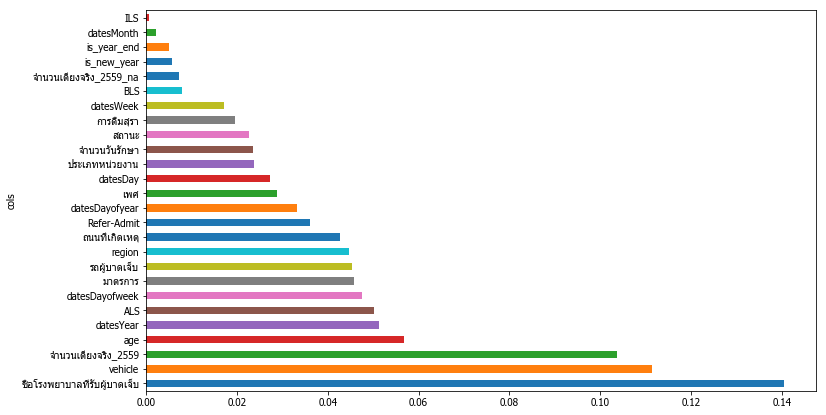

In [85]:
plot_fi(fi[:30]);

WHOA!! Look at here. Drinking alcohol is now fall to rank 19th. This mean when accident occured, drinkers weren't dead more than non-drinkers. But drinkers may caused incident of accident more than non-drinkers anyway.

In [86]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [87]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [88]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True, class_weight='balanced')
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98496585518427771, 0.98469958950118175, 0.98335505395402178]


In [89]:
fi = rf_feat_importance(m, df_keep); fi[:10]

,cols,imp
0,ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ,0.138756
1,vehicle,0.111479
2,จำนวนเตียงจริง_2559,0.098383
3,age,0.055699
4,datesYear,0.054370
6,datesDayofweek,0.047282
5,ALS,0.046227
10,ถนนที่เกิดเหตุ,0.045797
9,region,0.045224
7,มาตรการ,0.044041


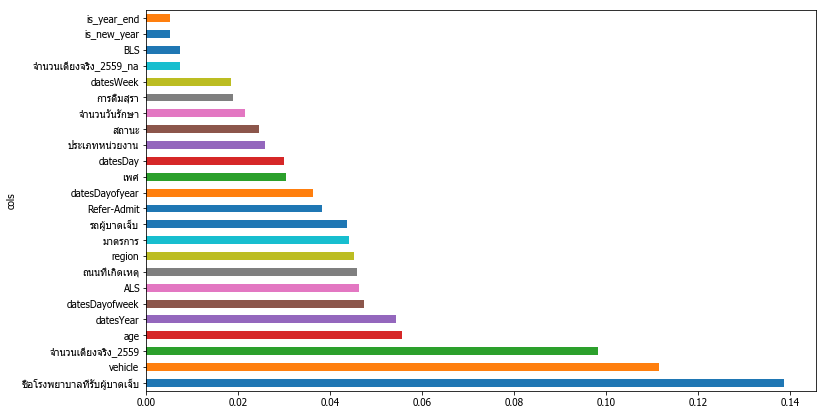

In [90]:
plot_fi(fi[:30]);

Next section, we will remove ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ because it did not tell anything much.

In [91]:
#Try drop hosp name
df_raw = pd.read_feather(f'{PATH}df')
df_nohosp = df_raw.copy()

In [92]:
df_nohosp.drop(["ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ"], axis=1, inplace=True)

In [93]:
df_trn2, y_trn, nas = proc_df(df_nohosp, 'result', max_n_cat=15)

In [94]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 24117  # Latest year (2015)
n_trn = len(df_trn2)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn2, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((191830, 82), (191830,), (24117, 82))

In [95]:
m = RandomForestClassifier(n_estimators=40,class_weight="balanced", min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98492936454152114, 0.98465812497408467, 0.98309961945472557]


In [96]:
fi = rf_feat_importance(m, df_trn2); fi[:10]

,cols,imp
1,จำนวนเตียงจริง_2559,0.116223
7,datesYear,0.056565
11,datesDayofweek,0.050695
5,ALS,0.048429
44,มาตรการ_ไม่ทราบ,0.046749
18,ถนนที่เกิดเหตุ_ทางหลวง,0.042602
12,datesDayofyear,0.036047
63,vehicle_Self,0.035083
10,datesDay,0.030319
64,vehicle_Small,0.026391


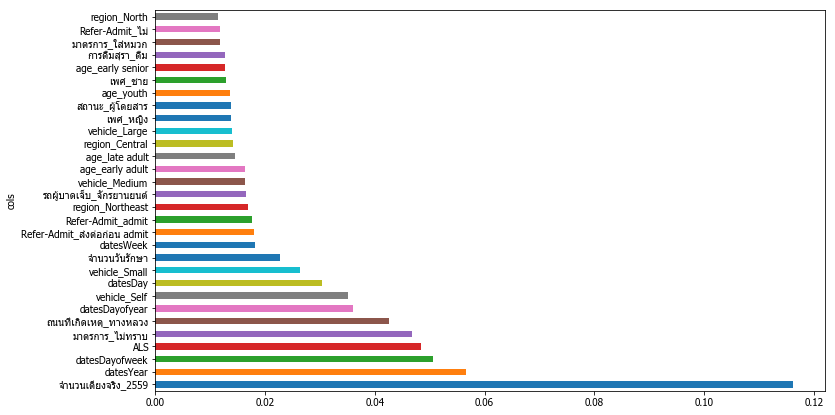

In [97]:
plot_fi(fi[:30]);

So here is it, we can keep gather more data and fill in the missing data.
Seems like amount of beds have important effect here. We will see in next sections.

   datesYear mean calendar year of accident, more ppl commute, more accident.

   datesDayofweek is interesting, maybe weekend have more effect than weekdays.

   ALS(Advanced life support) : This is came from severity of accident. If accident more  severe, more ALS needed, which mean more dead.
                            
   Unknown mode of protection : Which I don't understand why it is unknown especially motorcycle.  Data collection should be improved.  Anyway, from WHO data, helmet can reduce severe disabilities more than 90%.  I assume that this group didn't wear helmet.
   
   Other important factors such as dead usually occur in main road, maybe due to high speed riding or bad road condition.

Here we calculate recall, precise, and F-score. But as I told, this is a very unbalanced dataset. 
So it wouldn't help much in this dataset.

In [98]:
#Test with Imbalanced Learn

In [99]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from imblearn.datasets import make_imbalance
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import precision_recall_fscore_support

In [100]:
imb = BalancedBaggingClassifier(n_estimators=30, max_features=0.6, oob_score=True, n_jobs=-1)
imb.fit(X_train, y_train)
print_score(imb)

[array([0, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 0, 1, 1]), 0.73631861544075483, 0.74109549280590459, 0.69097638534118755]


In [101]:
#Compare m, imb using recall, precise, F_score

In [102]:
tn, fp, fn, tp = confusion_matrix(y_valid,m.predict(X_valid)).ravel()
print(tn,tp,fn,fp)

15 23732 17 353


In [103]:
precision_recall_fscore_support(y_valid,m.predict(X_valid), average='binary')

(0.9853435748391115, 0.99928418038654254, 0.99226491616841572, None)

In [104]:
tn, fp, fn, tp = confusion_matrix(y_valid,imb.predict(X_valid)).ravel()
print(tn,tp,fn,fp)

274 17599 6150 94


In [105]:
precision_recall_fscore_support(y_valid,imb.predict(X_valid), average='binary')

(0.99468716441530547, 0.74104172807276092, 0.84933159596544561, None)

In [106]:
#Removing redundant features
from scipy.cluster import hierarchy as hc

In [107]:
#Load data and do as previous section without onehotencoder
df_raw = pd.read_feather(f'{PATH}df')
df_nohosp = df_raw.copy()

In [108]:
df_nohosp.drop(["ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ"], axis=1, inplace=True)

In [109]:
df_trn2, y_trn, nas = proc_df(df_nohosp, 'result')

In [110]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 24117  # Latest year (2015)
n_trn = len(df_trn2)-n_valid
#raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn2, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((191830, 25), (191830,), (24117, 25))

Here we will using correrations to assist us removing correrated features

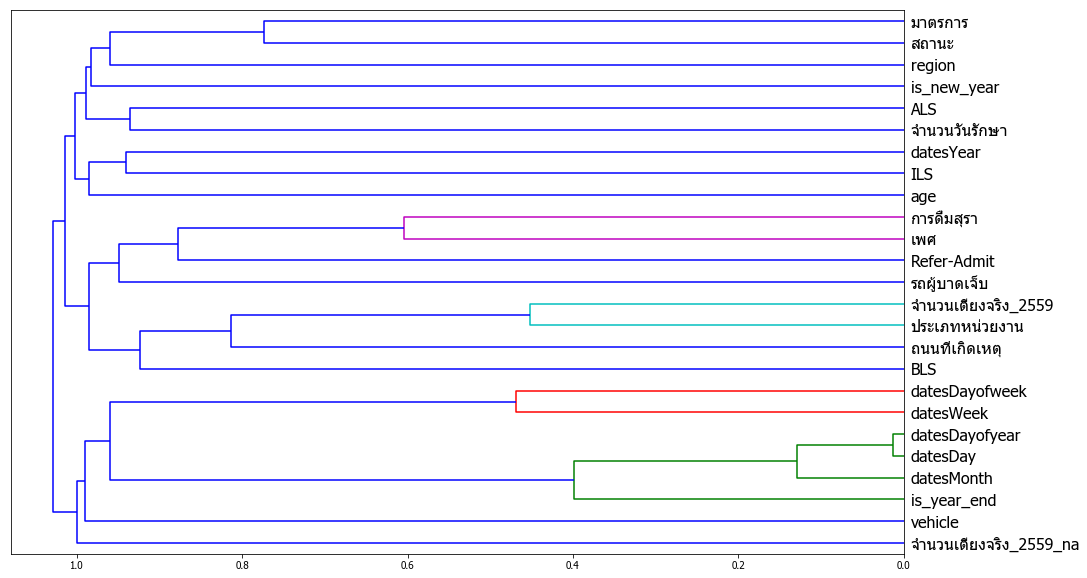

In [111]:
corr = np.round(scipy.stats.spearmanr(df_trn2).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_trn2.columns, orientation='left', leaf_font_size=16)
plt.show()

In [112]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=30, class_weight='balanced', min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [113]:
#Get baseline oob score
get_oob(df_trn2)

0.98173382682583532

In [114]:
#Now we try drop redundant features one-by-one and see if it changed our oob score much or not.
for c in ('is_year_end', 'datesMonth', 'datesDay', 'datesDayofyear', 'datesWeek', 'datesDayofweek', 'เพศ', 'การดื่มสุรา','จำนวนเตียงจริง_2559', 'ประเภทหน่วยงาน'):
    print(c, get_oob(df_trn2.drop(c, axis=1)))

is_year_end 0.982004900172
datesMonth 0.981937131835
datesDay 0.982109159151
datesDayofyear 0.981911067091
datesWeek 0.981431475786
datesDayofweek 0.981707762081
เพศ 0.98206745556
การดื่มสุรา 0.981832872856
จำนวนเตียงจริง_2559 0.980852838451
ประเภทหน่วยงาน 0.981848511703


In [115]:
to_drop = ['is_year_end', 'datesMonth', 'datesDayofyear', 'datesWeek', 'เพศ', 'จำนวนเตียงจริง_2559', 'จำนวนเตียงจริง_2559_na']
get_oob(df_trn2.drop(to_drop, axis=1))

0.980430589584528

In [116]:
df_trn2.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [117]:
np.save('tmp/trn2_cols.npy', np.array(df_trn2.columns))

In [127]:
keep_cols = np.load('tmp/trn2_cols.npy')
df_trn2 = df[keep_cols]

In [118]:
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestClassifier(n_estimators=40,class_weight="balanced", min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.98479904081739045, 0.98457519591989051, 0.98280769431267267]


In [119]:
fi = rf_feat_importance(m, df_trn2); fi[:10]

,cols,imp
12,vehicle,0.124287
13,age,0.090300
15,datesYear,0.086320
17,datesDayofweek,0.084972
14,region,0.083259
16,datesDay,0.078658
7,ประเภทหน่วยงาน,0.065773
0,ถนนที่เกิดเหตุ,0.059126
3,มาตรการ,0.057116
2,รถผู้บาดเจ็บ,0.054225


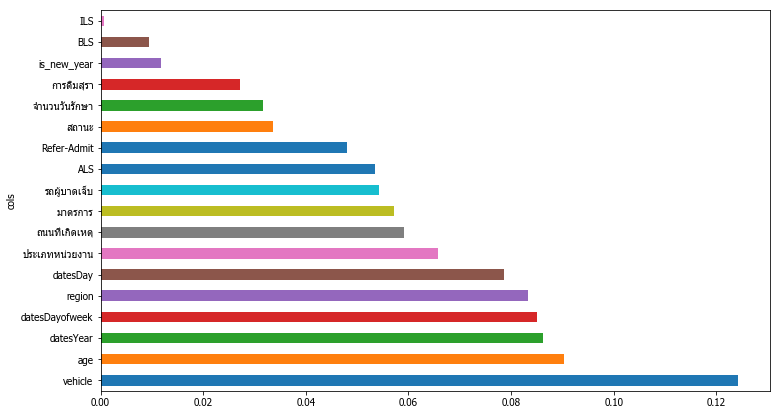

In [120]:
plot_fi(fi[:30])

In [121]:
reset_rf_samples()

In [122]:
m = RandomForestClassifier(n_estimators=40,class_weight="balanced", min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 1, 1]), 0.9909086170046395, 0.98200439523987226, 0.97297607256424956]


In [123]:
#Partial dependence
from pdpbox import pdp
from plotnine import *

In [124]:
set_rf_samples(50000)

In [130]:
df_trn2, y_trn, nas = proc_df(df_nohosp, 'result', max_n_cat=15)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, class_weight='balanced')
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features=0.6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

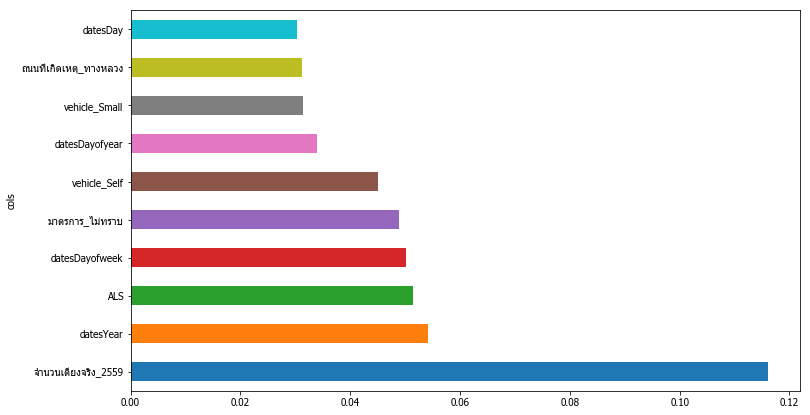

In [131]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

Now we take a look at amount of beds. Is it really the caused of more dead? 
Were smaller hospitals doing worse than larger hospitals?

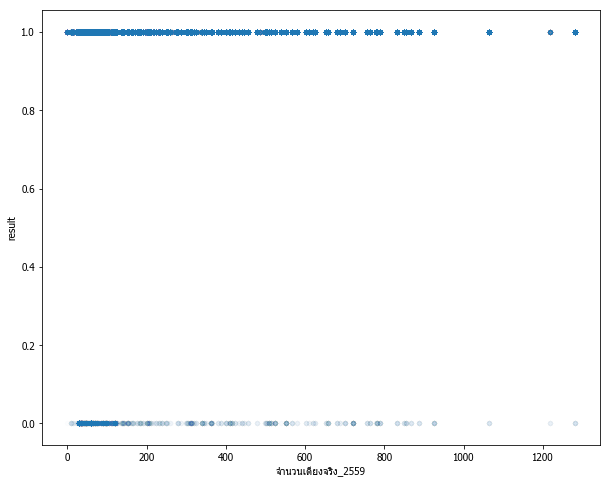

In [132]:
df_raw.plot('จำนวนเตียงจริง_2559', 'result', 'scatter', alpha=0.01, figsize=(10,8));

In [133]:
x_all = get_sample(df_raw[df_raw["จำนวนเตียงจริง_2559"]<250], 500)

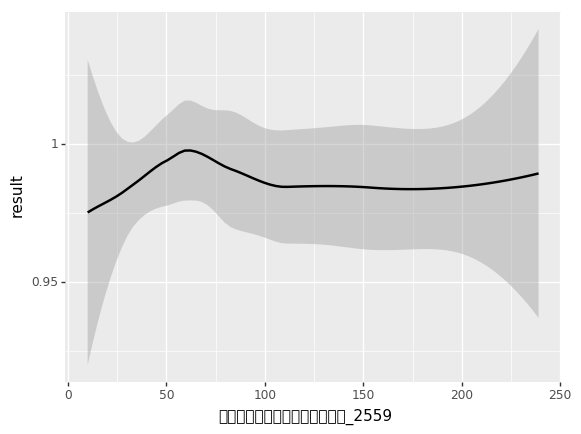

<ggplot: (7548611069)>

In [134]:
ggplot(x_all, aes('จำนวนเตียงจริง_2559', 'result'))+stat_smooth(se=True, method='loess')

Phew! seems that's not the case. Amount of beds didn't caused more dead.